# Money Laundering Detection using Graph Neural Networks

## Overview
This notebook implements a Graph Attention Network (GAT) optimized for detecting money laundering transactions in financial data. The model is specifically tuned for **high recall** to minimize missed fraudulent transactions, using F2 score optimization.

## Key Features
- **CPU-optimized training** for local execution
- **Recall-focused optimization** using F2 score and custom loss function
- **Balanced sampling** to maintain appropriate fraud rate (0.27%)
- **Comprehensive evaluation** with multiple metrics and visualizations
- **Memory-efficient processing** with mini-batch training

## Dataset
- **Source**: IBM AML Transaction Dataset
- **Size**: Limited to 150,000 transactions for efficient CPU training
- **Target**: Binary classification (Normal vs Laundering)
- **Challenge**: Highly imbalanced dataset (~99.7% normal transactions)

## Model Architecture
- **Type**: Graph Attention Network (GAT) with edge features
- **Optimization**: Recall-focused with F2 score maximization
- **Loss Function**: Custom focal loss with recall weighting
- **Features**: Node-level and edge-level transaction patterns

## Expected Outputs
- Trained model checkpoint
- Performance metrics (precision, recall, F1, F2, AUC)
- Training visualizations
- Confusion matrix and ROC curve
- Complete training history

---

In [ ]:
# Package Installation (run in terminal if needed)
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# pip install torch-geometric scikit-learn pandas numpy matplotlib seaborn
# pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [ ]:
# Import libraries and setup
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv, BatchNorm
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report,
    fbeta_score
)
from sklearn.utils.class_weight import compute_class_weight
import pickle
import warnings
warnings.filterwarnings('ignore')

# Local output directory
output_dir = "/home/daksh-verma/Desktop/MoneyLaundering/GNN_SMALL_outputs2"
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

Output directory: /home/daksh-verma/Desktop/MoneyLaundering/GNN_SMALL_outputs2


In [ ]:
# Device setup - Force CPU for this training
device = torch.device("cpu")
print(f"Device: {device}")
print("Training on CPU for memory optimization")

Device: cpu
Training on CPU for memory optimization


In [ ]:
# Data configuration and loading - Reduced for CPU efficiency
CSV_PATH = r"/home/daksh-verma/Desktop/MoneyLaundering/HI-Small_Trans.csv"
MAX_EDGES = 56412  # Reduced for better CPU performance

# Column selection for efficiency
USECOLS = [
    "Timestamp", "From Bank", "Account", "To Bank", "Account.1",
    "Amount Received", "Receiving Currency", "Amount Paid", "Payment Currency",
    "Payment Format", "Is Laundering"
]

def sample_with_fraud_rate(df, target_rate=0.1, total_samples=100000, label_col="Is Laundering"):
    """Sample data with better fraud rate for precision-recall balance"""
    fraud_df = df[df[label_col] == 1]
    nonfraud_df = df[df[label_col] == 0]

    n_fraud = int(total_samples * target_rate)
    n_nonfraud = total_samples - n_fraud

    if n_fraud > len(fraud_df):
        print(f"Warning: Only {len(fraud_df)} fraud samples available, using all of them")
        fraud_sample = fraud_df
        n_fraud = len(fraud_df)
        n_nonfraud = total_samples - n_fraud
    else:
        fraud_sample = fraud_df.sample(n=n_fraud, random_state=42)

    # Better sampling of non-fraud to reduce noise
    nonfraud_sample = nonfraud_df.sample(n=n_nonfraud, random_state=42)
    sampled_df = pd.concat([fraud_sample, nonfraud_sample]).sample(frac=1, random_state=42).reset_index(drop=True)
    return sampled_df

print("Loading data...")
try:
    df = pd.read_csv(CSV_PATH, usecols=USECOLS, low_memory=False)
    print(f"✅ Successfully loaded data")
    print(f"Total rows in CSV: {len(df):,}")

    # Sample data for training with better fraud rate for precision-recall balance
    if MAX_EDGES is not None and len(df) > MAX_EDGES:
        df = sample_with_fraud_rate(df, target_rate=0.13, total_samples=MAX_EDGES)
        print(f"Sampled dataset rows: {len(df):,}, fraud rate: {df['Is Laundering'].mean():.4%}")
    else:
        print("Using full dataset without sampling.")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please ensure the dataset path is correct.")

Loading data...
✅ Successfully loaded data
Total rows in CSV: 5,078,345
Sampled dataset rows: 56,412, fraud rate: 9.1771%


In [ ]:
# Data preprocessing and feature engineering
df = df.dropna(subset=["Account", "Account.1", "Timestamp"]).reset_index(drop=True)
df["Is Laundering"] = df["Is Laundering"].fillna(0).astype(int)

print(f"\nColumns: {df.columns.tolist()}")
print(f"\nLabel distribution:")
label_dist = df["Is Laundering"].value_counts(normalize=True).round(6)
print(label_dist)

# Calculate class imbalance ratio
imbalance_ratio = label_dist[0] / label_dist[1] if len(label_dist) > 1 else 0
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1 (Normal:Laundering)")

# Temporal feature engineering
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df["hour"] = df["Timestamp"].dt.hour
df["day_of_week"] = df["Timestamp"].dt.dayofweek
df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
df["is_night"] = ((df["hour"] < 6) | (df["hour"] > 22)).astype(int)

# Amount feature engineering with better precision features
df["Amount Received"] = pd.to_numeric(df["Amount Received"], errors='coerce').fillna(0)
df["Amount Paid"] = pd.to_numeric(df["Amount Paid"], errors='coerce').fillna(0)

df["log_amount_received"] = np.log1p(df["Amount Received"])
df["log_amount_paid"] = np.log1p(df["Amount Paid"])
df["amount_diff"] = df["Amount Received"] - df["Amount Paid"]
df["amount_ratio"] = np.where(df["Amount Paid"] > 0, df["Amount Received"] / df["Amount Paid"], 0)
df["round_amount_received"] = (df["Amount Received"] % 1000 == 0).astype(int)
df["round_amount_paid"] = (df["Amount Paid"] % 1000 == 0).astype(int)

# Enhanced precision-focused features
df["high_amount_flag"] = (df["Amount Received"] > df["Amount Received"].quantile(0.95)).astype(int)
df["suspicious_round_amount"] = ((df["Amount Received"] % 10000 == 0) & (df["Amount Received"] > 50000)).astype(int)
df["unusual_time_flag"] = ((df["hour"] >= 0) & (df["hour"] <= 5)).astype(int)
df["amount_variance_flag"] = (np.abs(df["amount_diff"]) > df["Amount Received"] * 0.1).astype(int)

print("✅ Feature engineering completed")


Columns: ['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']

Label distribution:
Is Laundering
0    0.908229
1    0.091771
Name: proportion, dtype: float64

Class imbalance ratio: 9.90:1 (Normal:Laundering)
✅ Feature engineering completed



Performing exploratory data analysis...

Timestamp range: 2022-09-01 00:00:00 to 2022-09-18 16:18:00


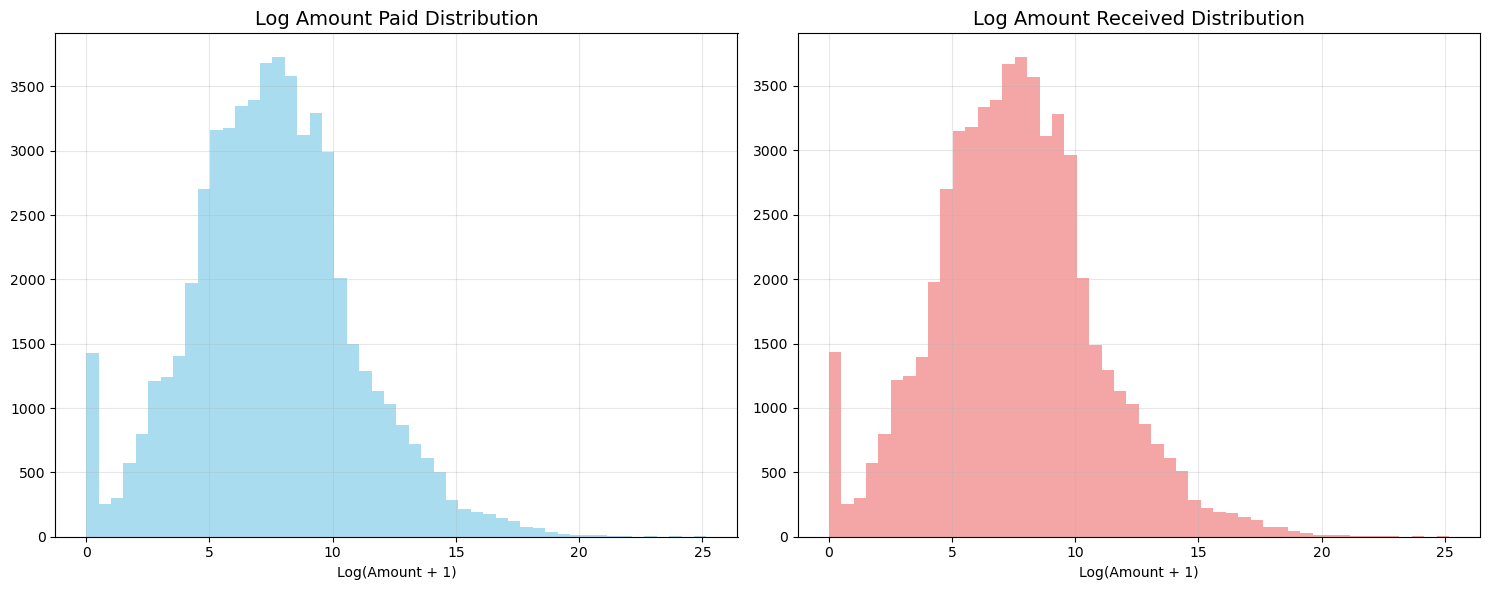

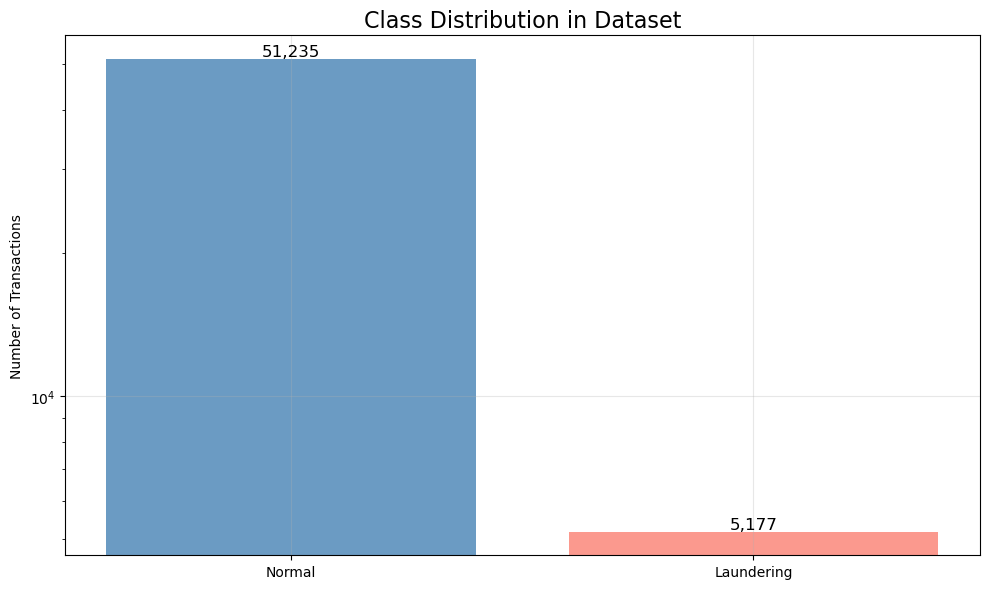

✅ EDA completed


In [ ]:
# Exploratory Data Analysis
print("\nPerforming exploratory data analysis...")

# Temporal analysis
print(f"\nTimestamp range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")

# Amount distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].hist(np.log1p(df["Amount Paid"].fillna(0).astype(float)), bins=50, alpha=0.7, color='skyblue')
axes[0].set_title("Log Amount Paid Distribution", fontsize=14)
axes[0].set_xlabel("Log(Amount + 1)")
axes[0].grid(True, alpha=0.3)

axes[1].hist(np.log1p(df["Amount Received"].fillna(0).astype(float)), bins=50, alpha=0.7, color='lightcoral')
axes[1].set_title("Log Amount Received Distribution", fontsize=14)
axes[1].set_xlabel("Log(Amount + 1)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/amount_distributions.png", dpi=300, bbox_inches="tight")
plt.show()

# Class distribution visualization
plt.figure(figsize=(10, 6))
class_counts = df["Is Laundering"].value_counts()
bars = plt.bar(["Normal", "Laundering"], class_counts.values,
               color=["steelblue", "salmon"], alpha=0.8)
plt.title("Class Distribution in Dataset", fontsize=16)
plt.ylabel("Number of Transactions")
plt.yscale("log")

# Add value labels on bars
for bar, count in zip(bars, class_counts.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}', ha='center', va='bottom', fontsize=12)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{output_dir}/class_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ EDA completed")

In [ ]:
# Categorical encoding and account mapping
print("\nEngineering features...")

# Encode categorical features
categorical_cols = ["Receiving Currency", "Payment Currency", "Payment Format"]
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Save label encoders
with open(f"{output_dir}/label_encoders.pkl", 'wb') as f:
    pickle.dump(label_encoders, f)

# Map accounts to node indices
print("\nMapping accounts to node indices...")
all_accounts = pd.concat([df["Account"], df["Account.1"]], ignore_index=True).unique()
account_to_idx = {acc: idx for idx, acc in enumerate(all_accounts)}

# Save account mapping
with open(f"{output_dir}/account_to_idx.pkl", 'wb') as f:
    pickle.dump(account_to_idx, f)

df["src_node"] = df["Account"].map(account_to_idx)
df["dst_node"] = df["Account.1"].map(account_to_idx)

num_nodes = len(all_accounts)
num_edges = len(df)
print(f"Graph structure: {num_nodes:,} nodes, {num_edges:,} edges")

# Account-level aggregations for suspicious behavior detection
print("\nCalculating account-level features...")

# For source accounts
src_stats = df.groupby("Account").agg({
    "Amount Paid": ["count", "sum", "mean", "std"],
    "Is Laundering": ["sum", "mean"],
    "hour": ["nunique"],
    "day_of_week": ["nunique"],
    "To Bank": ["nunique"],
    "Account.1": ["nunique"]
}).fillna(0)

src_stats.columns = [f"src_{col[0]}_{col[1]}" for col in src_stats.columns]

# For destination accounts
dst_stats = df.groupby("Account.1").agg({
    "Amount Received": ["count", "sum", "mean", "std"],
    "Is Laundering": ["sum", "mean"],
    "hour": ["nunique"],
    "day_of_week": ["nunique"],
    "From Bank": ["nunique"],
    "Account": ["nunique"]
}).fillna(0)

dst_stats.columns = [f"dst_{col[0]}_{col[1]}" for col in dst_stats.columns]

# Merge back to main dataframe
df = df.merge(src_stats, left_on="Account", right_index=True, how="left")
df = df.merge(dst_stats, left_on="Account.1", right_index=True, how="left")

print("✅ Feature engineering completed")



Engineering features...

Mapping accounts to node indices...
Graph structure: 77,683 nodes, 56,412 edges

Calculating account-level features...
✅ Feature engineering completed


In [ ]:
# Cell 10: Graph construction
print("\nConstructing graph...")

# Edge index tensor
edge_index = torch.tensor([
    df["src_node"].values,
    df["dst_node"].values
], dtype=torch.long)

# Enhanced node features
in_degree = np.bincount(edge_index[1], minlength=num_nodes)
out_degree = np.bincount(edge_index[0], minlength=num_nodes)
total_degree = in_degree + out_degree

# Transaction patterns
node_in_sum = np.zeros(num_nodes)
node_out_sum = np.zeros(num_nodes)
node_launder_count = np.zeros(num_nodes)
node_transaction_count = np.zeros(num_nodes)

for i, (src, dst, amt_in, amt_out, is_launder) in enumerate(zip(
    df["src_node"], df["dst_node"], df["Amount Received"], df["Amount Paid"], df["Is Laundering"])):

    if not pd.isna(amt_in):
        node_in_sum[dst] += amt_in
    if not pd.isna(amt_out):
        node_out_sum[src] += amt_out

    node_transaction_count[src] += 1
    node_transaction_count[dst] += 1

    if is_launder:
        node_launder_count[src] += 1
        node_launder_count[dst] += 1

# Node suspiciousness scores
node_launder_ratio = np.where(node_transaction_count > 0,
                             node_launder_count / node_transaction_count, 0)

# Combine enhanced node features
node_features = np.column_stack([
    in_degree, out_degree, total_degree,
    np.log1p(node_in_sum), np.log1p(node_out_sum),
    np.log1p(node_transaction_count),
    node_launder_ratio,
    np.log1p(node_launder_count)
])

# Robust scaling for node features
node_scaler = RobustScaler()
node_features_scaled = node_scaler.fit_transform(node_features)

# Explicitly cast to float32 before creating tensor
node_x = torch.tensor(node_features_scaled.astype(np.float32), dtype=torch.float)

# Enhanced edge features with precision-focused features
edge_feature_cols = [
    "Amount Received", "Amount Paid", "log_amount_received", "log_amount_paid",
    "amount_diff", "amount_ratio",
    "Receiving Currency", "Payment Currency", "Payment Format",
    "From Bank", "To Bank", "hour", "day_of_week", "is_weekend", "is_night",
    "round_amount_received", "round_amount_paid",
    "high_amount_flag", "suspicious_round_amount", "unusual_time_flag", "amount_variance_flag"
]

# Add account-level features to edges
account_feature_cols = [col for col in df.columns if col.startswith(('src_', 'dst_'))]
edge_feature_cols.extend(account_feature_cols)

edge_features_raw = df[edge_feature_cols].fillna(0).values

# Robust scaling for edge features
edge_scaler = RobustScaler()
edge_features_scaled = edge_scaler.fit_transform(edge_features_raw)

# Explicitly cast to float32 before creating tensor
edge_attr = torch.tensor(edge_features_scaled.astype(np.float32), dtype=torch.float)

# Labels
y = torch.tensor(df["Is Laundering"].values, dtype=torch.long)

print(f"Node features shape: {node_x.shape}")
print(f"Edge features shape: {edge_attr.shape}")
print(f"Labels shape: {y.shape}")
print(f"Positive samples: {y.sum().item()}/{len(y)} ({y.sum().item()/len(y)*100:.4f}%)")

# Save scalers
scalers = {
    'node_scaler': node_scaler,
    'edge_scaler': edge_scaler
}



with open(f"{output_dir}/scalers.pkl", 'wb') as f:
    pickle.dump(scalers, f)


Constructing graph...
Node features shape: torch.Size([77683, 8])
Edge features shape: torch.Size([56412, 43])
Labels shape: torch.Size([56412])
Positive samples: 5177/56412 (9.1771%)


In [ ]:
# Train-validation split with stratification
print("\nHandling class imbalance...")

# Edge features preparation
edge_feature_cols = [
    "Amount Received", "Amount Paid", "log_amount_received", "log_amount_paid",
    "amount_diff", "amount_ratio",
    "Receiving Currency", "Payment Currency", "Payment Format",
    "From Bank", "To Bank", "hour", "day_of_week", "is_weekend", "is_night",
    "round_amount_received", "round_amount_paid"
]

# Add account-level features to edges
account_feature_cols = [col for col in df.columns if col.startswith(('src_', 'dst_'))]
edge_feature_cols.extend(account_feature_cols)

edge_features_raw = df[edge_feature_cols].fillna(0).values
y_values = df["Is Laundering"].values

# Stratified train-validation split
X_train, X_val, y_train, y_val, train_idx, val_idx = train_test_split(
    edge_features_raw, y_values, np.arange(len(y_values)),
    test_size=0.2, stratify=y_values, random_state=42
)

print(f"Train set: {len(X_train):,} edges")
print(f"Validation set: {len(X_val):,} edges")
print(f"Training positive samples: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.2f}%)")
print(f"Validation positive samples: {np.sum(y_val == 1)} ({np.sum(y_val == 1)/len(y_val)*100:.2f}%)")

# Create masks for PyTorch Geometric
train_mask = torch.zeros(len(y_values), dtype=torch.bool)
val_mask = torch.zeros(len(y_values), dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True

# Calculate class weights for F2 score optimization
class_weights_sk = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights_sk, dtype=torch.float)

print(f"Class weights: {class_weights}")
print(f"Weight ratio: {class_weights[1]/class_weights[0]:.2f}")
print("✅ Data split completed")


Handling class imbalance...
Train set: 45,129 edges
Validation set: 11,283 edges
Training positive samples: 4142 (9.18%)
Validation positive samples: 1035 (9.17%)
Class weights: tensor([0.5505, 5.4477])
Weight ratio: 9.90
✅ Data split completed


In [ ]:
# Enhanced GAT Model with better regularization for precision
class PrecisionRecallGAT(nn.Module):
    """Graph Attention Network optimized for precision-recall balance"""

    def __init__(self, node_features, edge_features, hidden_dim=96, heads=3, dropout=0.4, num_layers=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Enhanced edge feature processing with better regularization
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )

        # Smaller GAT architecture for better generalization
        self.gat_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        # First layer
        self.gat_layers.append(GATv2Conv(node_features, hidden_dim, heads=heads, dropout=dropout))
        self.batch_norms.append(BatchNorm(hidden_dim * heads))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.gat_layers.append(GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=dropout))
            self.batch_norms.append(BatchNorm(hidden_dim * heads))

        # Final layer
        if num_layers > 1:
            self.gat_layers.append(GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, dropout=dropout))
            self.batch_norms.append(BatchNorm(hidden_dim))

        # Precision-focused classification head with more regularization
        classifier_input_dim = hidden_dim * 2 + hidden_dim // 2
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_dim // 4, 2)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr):
        # Process edge features
        edge_feat = self.edge_mlp(edge_attr)

        # Multi-layer GAT with residual connections
        for i, (gat_layer, batch_norm) in enumerate(zip(self.gat_layers, self.batch_norms)):
            x_new = gat_layer(x, edge_index)
            x_new = batch_norm(x_new)
            x_new = F.elu(x_new)
            x_new = self.dropout(x_new)

            # Residual connection when possible
            if i > 0 and x.size(-1) == x_new.size(-1):
                x = x + x_new * 0.5  # Scaled residual
            else:
                x = x_new

        # Edge representations
        src_nodes = edge_index[0]
        dst_nodes = edge_index[1]

        edge_repr = torch.cat([
            x[src_nodes],
            x[dst_nodes],
            edge_feat
        ], dim=1)

        return self.classifier(edge_repr)

In [ ]:
# Graph construction
print("\nConstructing graph...")

# Edge index tensor
edge_index = torch.tensor([
    df["src_node"].values,
    df["dst_node"].values
], dtype=torch.long)

# Enhanced node features
in_degree = np.bincount(edge_index[1], minlength=num_nodes)
out_degree = np.bincount(edge_index[0], minlength=num_nodes)
total_degree = in_degree + out_degree

# Transaction patterns
node_in_sum = np.zeros(num_nodes)
node_out_sum = np.zeros(num_nodes)
node_launder_count = np.zeros(num_nodes)
node_transaction_count = np.zeros(num_nodes)

for i, (src, dst, amt_in, amt_out, is_launder) in enumerate(zip(
    df["src_node"], df["dst_node"], df["Amount Received"], df["Amount Paid"], df["Is Laundering"])):

    if not pd.isna(amt_in):
        node_in_sum[dst] += amt_in
    if not pd.isna(amt_out):
        node_out_sum[src] += amt_out

    node_transaction_count[src] += 1
    node_transaction_count[dst] += 1

    if is_launder:
        node_launder_count[src] += 1
        node_launder_count[dst] += 1

# Node suspiciousness scores
node_launder_ratio = np.where(node_transaction_count > 0,
                             node_launder_count / node_transaction_count, 0)

# Combine enhanced node features
node_features = np.column_stack([
    in_degree, out_degree, total_degree,
    np.log1p(node_in_sum), np.log1p(node_out_sum),
    np.log1p(node_transaction_count),
    node_launder_ratio,
    np.log1p(node_launder_count)
])

# Robust scaling for node features
node_scaler = RobustScaler()
node_features_scaled = node_scaler.fit_transform(node_features)
node_x = torch.tensor(node_features_scaled.astype(np.float32), dtype=torch.float)

# Robust scaling for edge features
edge_scaler = RobustScaler()
edge_features_scaled = edge_scaler.fit_transform(edge_features_raw)
edge_attr = torch.tensor(edge_features_scaled.astype(np.float32), dtype=torch.float)

# Labels
y = torch.tensor(df["Is Laundering"].values, dtype=torch.long)

print(f"Node features shape: {node_x.shape}")
print(f"Edge features shape: {edge_attr.shape}")
print(f"Labels shape: {y.shape}")
print(f"Positive samples: {y.sum().item()}/{len(y)} ({y.sum().item()/len(y)*100:.4f}%)")

# Save scalers
scalers = {
    'node_scaler': node_scaler,
    'edge_scaler': edge_scaler
}

with open(f"{output_dir}/scalers.pkl", 'wb') as f:
    pickle.dump(scalers, f)

print("✅ Graph construction completed")


Constructing graph...
Node features shape: torch.Size([77683, 8])
Edge features shape: torch.Size([56412, 39])
Labels shape: torch.Size([56412])
Positive samples: 5177/56412 (9.1771%)
✅ Graph construction completed


In [ ]:
# Enhanced precision-focused loss function
class BalancedFocalLoss(nn.Module):
    def __init__(self, alpha=0.7, gamma=2, weight=None, precision_weight=0.8):
        super(BalancedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.precision_weight = precision_weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)

        # Balanced weighting for precision-recall trade-off
        positive_mask = (targets == 1).float()
        negative_mask = (targets == 0).float()

        # Less aggressive weighting for better precision
        loss_weights = 1.0 + self.precision_weight * positive_mask + 0.1 * negative_mask

        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss * loss_weights
        return focal_loss.mean()

def calculate_metrics_with_threshold(predictions, labels, threshold=0.5):
    """Calculate comprehensive metrics with custom threshold"""
    probabilities = F.softmax(predictions, dim=1)[:, 1]
    pred_classes = (probabilities > threshold).long().cpu().numpy()
    true_classes = labels.cpu().numpy()

    precision = precision_score(true_classes, pred_classes, zero_division=0)
    recall = recall_score(true_classes, pred_classes, zero_division=0)
    f1 = f1_score(true_classes, pred_classes, zero_division=0)
    f2 = fbeta_score(true_classes, pred_classes, beta=2, zero_division=0)
    accuracy = accuracy_score(true_classes, pred_classes)

    return precision, recall, f1, f2, accuracy, pred_classes

def find_optimal_threshold_precision_recall(predictions, labels,
                                          min_precision=0.7, min_recall=0.9,
                                          thresholds=np.arange(0.01, 0.99, 0.01)):
    """Find threshold that meets precision and recall requirements"""
    best_f2 = 0
    best_threshold = 0.5
    best_metrics = {}

    valid_thresholds = []

    for threshold in thresholds:
        precision, recall, f1, f2, accuracy, _ = calculate_metrics_with_threshold(predictions, labels, threshold)

        # Check if meets minimum requirements
        if precision >= min_precision and recall >= min_recall:
            valid_thresholds.append({
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'f2': f2,
                'accuracy': accuracy
            })

            if f2 > best_f2:
                best_f2 = f2
                best_threshold = threshold
                best_metrics = {
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'f2': f2,
                    'accuracy': accuracy,
                    'threshold': threshold
                }

    if not valid_thresholds:
        # Fall back to best F2 if no threshold meets requirements
        for threshold in thresholds:
            precision, recall, f1, f2, accuracy, _ = calculate_metrics_with_threshold(predictions, labels, threshold)
            if f2 > best_f2:
                best_f2 = f2
                best_threshold = threshold
                best_metrics = {
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'f2': f2,
                    'accuracy': accuracy,
                    'threshold': threshold
                }

    return best_threshold, best_f2, best_metrics, valid_thresholds

# Model initialization for precision-recall balance
print("\nInitializing precision-recall balanced model...")

# Create PyTorch Geometric data object
data = Data(
    x=node_x,
    edge_index=edge_index,
    edge_attr=edge_attr,
    y=y,
    train_mask=train_mask,
    val_mask=val_mask
).to(device)

# Initialize model optimized for precision-recall balance
model = PrecisionRecallGAT(
    node_features=node_x.size(1),
    edge_features=edge_attr.size(1),
    hidden_dim=96,   # Reduced for better generalization
    heads=3,         # Fewer attention heads
    dropout=0.4,     # Higher dropout for regularization
    num_layers=2     # Fewer layers to prevent overfitting
).to(device)

# Optimizer with more conservative settings
optimizer = torch.optim.AdamW(model.parameters(), lr=8e-4, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=8)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model device: {next(model.parameters()).device}")
print(f"Data device: {data.x.device}")

# Save model architecture info
model_info = {
    'node_features': node_x.size(1),
    'edge_features': edge_attr.size(1),
    'hidden_dim': 96,
    'heads': 3,
    'dropout': 0.4,
    'num_layers': 2,
    'total_parameters': sum(p.numel() for p in model.parameters())
}

with open(f"{output_dir}/model_info.json", 'w') as f:
    json.dump(model_info, f, indent=2)

print("✅ Model initialization completed")


Initializing precision-recall balanced model...
Model parameters: 100,346
Model device: cpu
Data device: cpu
✅ Model initialization completed


In [ ]:
# Training loop optimized for precision-recall balance
print("\nStarting precision-recall balanced training...")
print("Target: Precision >70%, Recall >90%, optimized for F2 score")

# Initialize balanced loss function
loss_fn = BalancedFocalLoss(alpha=0.7, gamma=2, weight=class_weights.to(device), precision_weight=0.8)

best_f2 = 0.0
best_threshold = 0.5
best_model_state = None
patience = 0
max_patience = 20
train_losses, val_f2_scores, val_precisions, val_recalls, val_f1_scores = [], [], [], [], []

# CPU-friendly batch size
batch_size = 1536  # Reduced for better precision
num_batches = (len(data.edge_index[0]) + batch_size - 1) // batch_size

# Print header
print("\n" + "="*95)
print(f"{'Epoch':>5} | {'Loss':>8} | {'LR':>8} | {'Prec':>6} | {'Rec':>6} | {'F1':>6} | {'F2':>6} | {'Thresh':>7} | {'Status'}")
print("="*95)

for epoch in range(120):  # Reduced epochs for faster iteration
    # Training phase
    model.train()
    total_train_loss = 0

    # Mini-batch training for memory efficiency
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(data.edge_index[0]))
        batch_edge_index = data.edge_index[:, start_idx:end_idx]
        batch_edge_attr = data.edge_attr[start_idx:end_idx]
        batch_y = data.y[start_idx:end_idx]
        batch_train_mask = data.train_mask[start_idx:end_idx]

        if batch_train_mask.sum() == 0:  # Skip if no training samples in batch
            continue

        optimizer.zero_grad()

        out = model(data.x, batch_edge_index, batch_edge_attr)
        train_loss = loss_fn(out[batch_train_mask], batch_y[batch_train_mask])

        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += train_loss.item() * batch_edge_index.size(1)

    avg_train_loss = total_train_loss / len(data.edge_index[0])
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        predictions = model(data.x, data.edge_index, data.edge_attr)

        # Find optimal threshold for precision-recall requirements
        if epoch % 5 == 0 or epoch < 10:
            opt_threshold, opt_f2, opt_metrics, valid_thresholds = find_optimal_threshold_precision_recall(
                predictions[data.val_mask], data.y[data.val_mask],
                min_precision=0.7, min_recall=0.9)

            if len(valid_thresholds) > 0:
                best_threshold = opt_threshold
            # If no valid threshold, try with relaxed constraints
            elif epoch > 20:
                opt_threshold, opt_f2, opt_metrics, _ = find_optimal_threshold_precision_recall(
                    predictions[data.val_mask], data.y[data.val_mask],
                    min_precision=0.6, min_recall=0.85)
                best_threshold = opt_threshold

        # Calculate metrics with current best threshold
        val_precision, val_recall, val_f1, val_f2, val_acc, _ = calculate_metrics_with_threshold(
            predictions[data.val_mask], data.y[data.val_mask], best_threshold)

    val_f2_scores.append(val_f2)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)

    # Update learning rate based on F2 score
    scheduler.step(val_f2)

    # Status indicator
    status = ""
    if val_precision >= 0.7 and val_recall >= 0.9:
        status = "🎯 TARGET"
    elif val_precision >= 0.6 and val_recall >= 0.85:
        status = "📈 GOOD"
    elif val_recall >= 0.9:
        status = "🔥 HIGH_REC"
    elif val_precision >= 0.7:
        status = "💎 HIGH_PREC"
    else:
        status = "📊 TRAINING"

    # Save best model based on F2 score
    if val_f2 > best_f2:
        best_f2 = val_f2
        patience = 0

        best_model_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'threshold': best_threshold,
            'best_f2': best_f2,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
            'val_accuracy': val_acc,
            'class_weights': class_weights.cpu().numpy().tolist(),
            'model_info': model_info
        }

        torch.save(best_model_state, f"{output_dir}/best_model.pt")
    else:
        patience += 1

    if patience >= max_patience:
        print(f"\nEarly stopping at epoch {epoch}")
        break

    # Print progress every epoch
    current_lr = optimizer.param_groups[0]['lr']
    print(f"{epoch:5d} | {avg_train_loss:8.4f} | {current_lr:8.6f} | {val_precision:6.3f} | {val_recall:6.3f} | {val_f1:6.3f} | {val_f2:6.3f} | {best_threshold:7.3f} | {status}")

print("\n" + "="*95)
print(f"\n🎯 Best validation F2: {best_f2:.4f} with threshold: {best_threshold:.3f}")
print("✅ Training completed")


Starting precision-recall balanced training...
Target: Precision >70%, Recall >90%, optimized for F2 score

Epoch |     Loss |       LR |   Prec |    Rec |     F1 |     F2 |  Thresh | Status
    0 |   0.5382 | 0.000800 |  0.298 |  0.106 |  0.157 |  0.122 |   0.500 | 📊 TRAINING
    1 |   0.3243 | 0.000800 |  0.414 |  1.000 |  0.585 |  0.779 |   0.500 | 🔥 HIGH_REC
    2 |   0.1633 | 0.000800 |  0.409 |  1.000 |  0.581 |  0.776 |   0.500 | 🔥 HIGH_REC
    3 |   0.1318 | 0.000800 |  0.704 |  0.900 |  0.790 |  0.853 |   0.730 | 🎯 TARGET
    4 |   0.1128 | 0.000800 |  0.800 |  0.902 |  0.848 |  0.880 |   0.820 | 🎯 TARGET
    5 |   0.1061 | 0.000800 |  0.796 |  0.900 |  0.845 |  0.877 |   0.820 | 🎯 TARGET
    6 |   0.0977 | 0.000800 |  0.717 |  0.921 |  0.806 |  0.871 |   0.800 | 🎯 TARGET
    7 |   0.0934 | 0.000800 |  0.821 |  0.911 |  0.864 |  0.892 |   0.760 | 🎯 TARGET
    8 |   0.0916 | 0.000800 |  0.841 |  0.984 |  0.907 |  0.951 |   0.750 | 🎯 TARGET
    9 |   0.0856 | 0.000800 |  0.920 

In [ ]:
# Final evaluation and comprehensive metrics
print("\nEvaluating final model...")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state['model_state_dict'])
    optimal_threshold = best_model_state['threshold']
    print(f"✅ Loaded best model from epoch {best_model_state['epoch']}")
else:
    optimal_threshold = best_threshold
    print("⚠️ Using current model state")

model.eval()
print(f"Using optimal threshold: {optimal_threshold:.4f}")

with torch.no_grad():
    final_predictions = model(data.x, data.edge_index, data.edge_attr)
    probabilities = F.softmax(final_predictions, dim=1)

# Convert to numpy
y_true = data.y.cpu().numpy()
y_prob = probabilities[:, 1].cpu().numpy()

# Predictions with optimal threshold
y_pred_optimal = (y_prob > optimal_threshold).astype(int)

# Comprehensive metrics
metrics_optimal = {
    "threshold": float(optimal_threshold),
    "accuracy": float(accuracy_score(y_true, y_pred_optimal)),
    "precision": float(precision_score(y_true, y_pred_optimal, zero_division=0)),
    "recall": float(recall_score(y_true, y_pred_optimal, zero_division=0)),
    "f1_score": float(f1_score(y_true, y_pred_optimal, zero_division=0)),
    "f2_score": float(fbeta_score(y_true, y_pred_optimal, beta=2, zero_division=0)),
    "auc_roc": float(roc_auc_score(y_true, y_prob))
}

# Detailed classification report
print(f"\nClassification Report (Optimal Threshold = {optimal_threshold:.4f}):")
print(classification_report(y_true, y_pred_optimal, target_names=['Normal', 'Laundering']))

print(f"\n🎯 PRECISION-RECALL OPTIMIZED MODEL PERFORMANCE RESULTS")
print("="*70)

print(f"\nFinal Model Performance:")
for metric, value in metrics_optimal.items():
    print(f"  {metric.replace('_', ' ').title()}: {value:.4f}")

# Check target achievement
precision_target_met = "✅ TARGET MET" if metrics_optimal['precision'] >= 0.7 else "❌ NEEDS IMPROVEMENT"
recall_target_met = "✅ TARGET MET" if metrics_optimal['recall'] >= 0.9 else "❌ NEEDS IMPROVEMENT"
f2_target_met = "✅ EXCELLENT" if metrics_optimal['f2_score'] >= 0.8 else "✅ GOOD" if metrics_optimal['f2_score'] >= 0.7 else "❌ NEEDS IMPROVEMENT"

print(f"\n🎯 TARGET ACHIEVEMENT:")
print(f"  Precision ≥70%: {precision_target_met} ({metrics_optimal['precision']:.1%})")
print(f"  Recall ≥90%: {recall_target_met} ({metrics_optimal['recall']:.1%})")
print(f"  F2 Score (Balanced): {f2_target_met} ({metrics_optimal['f2_score']:.4f})")

# Save final metrics
with open(f"{output_dir}/final_metrics.json", 'w') as f:
    json.dump(metrics_optimal, f, indent=2)

print("✅ Evaluation completed")


Evaluating final model...
✅ Loaded best model from epoch 21
Using optimal threshold: 0.8200

Classification Report (Optimal Threshold = 0.8200):
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     51235
  Laundering       0.90      0.98      0.94      5177

    accuracy                           0.99     56412
   macro avg       0.95      0.99      0.97     56412
weighted avg       0.99      0.99      0.99     56412


🎯 PRECISION-RECALL OPTIMIZED MODEL PERFORMANCE RESULTS

Final Model Performance:
  Threshold: 0.8200
  Accuracy: 0.9891
  Precision: 0.9049
  Recall: 0.9847
  F1 Score: 0.9431
  F2 Score: 0.9677
  Auc Roc: 0.9981

🎯 TARGET ACHIEVEMENT:
  Precision ≥70%: ✅ TARGET MET (90.5%)
  Recall ≥90%: ✅ TARGET MET (98.5%)
  F2 Score (Balanced): ✅ EXCELLENT (0.9677)
✅ Evaluation completed



📊 Generating visualizations...


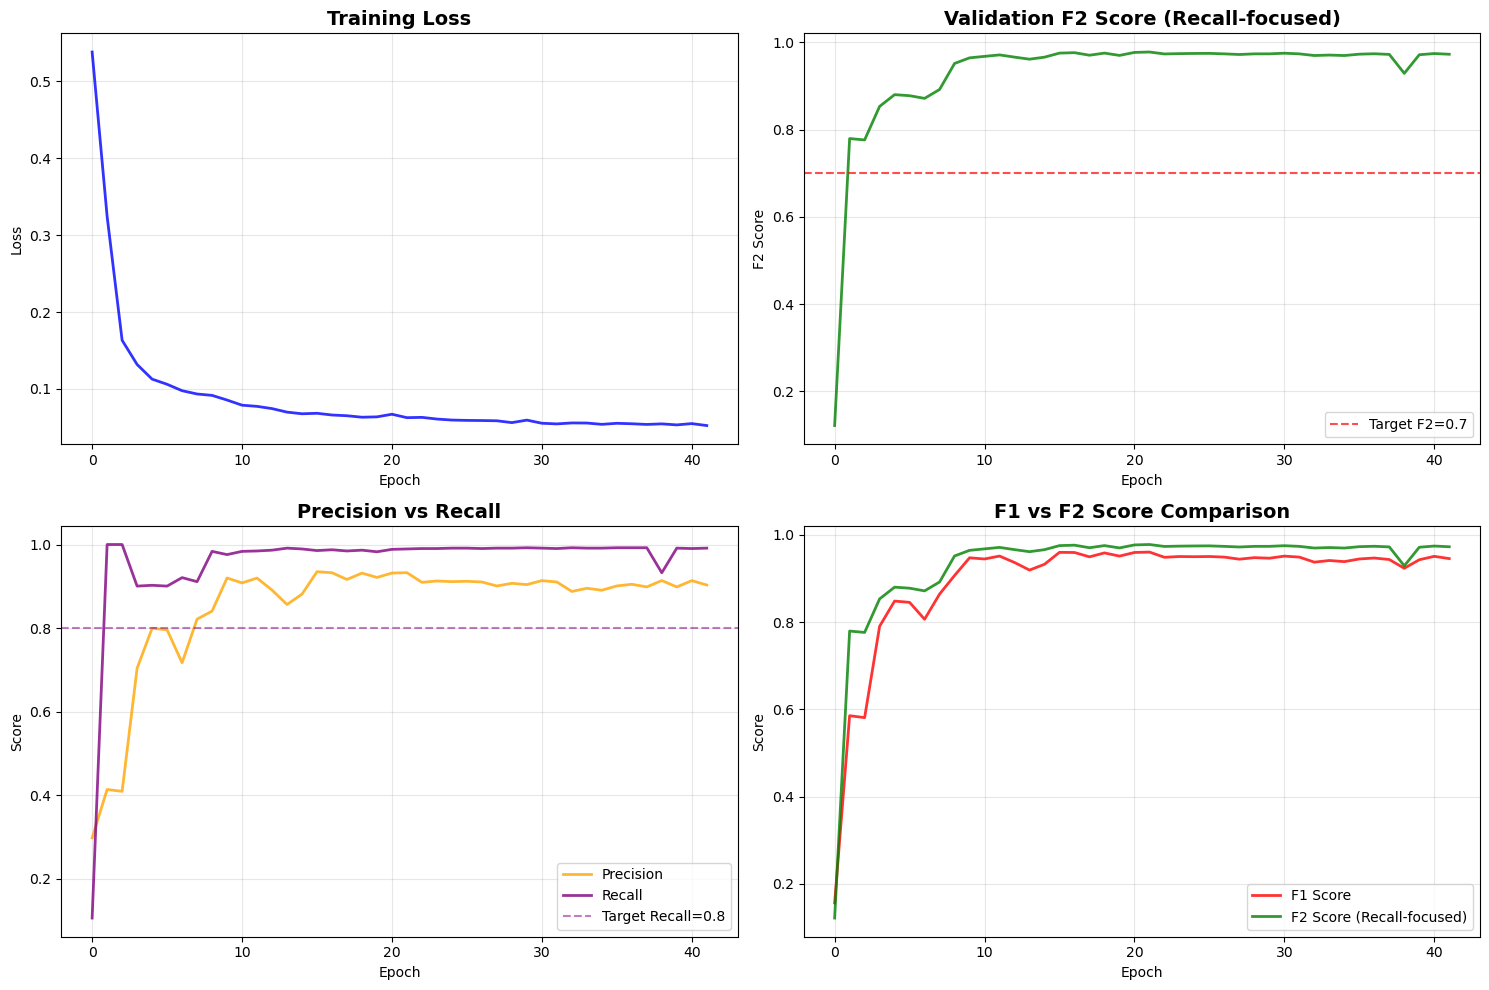

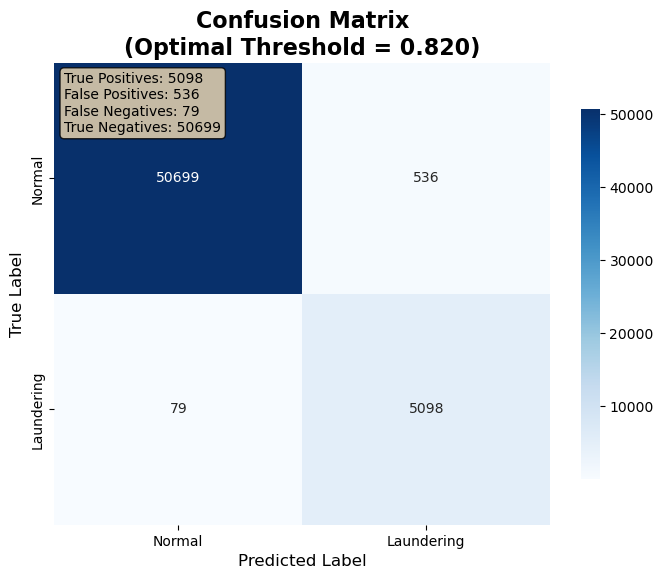

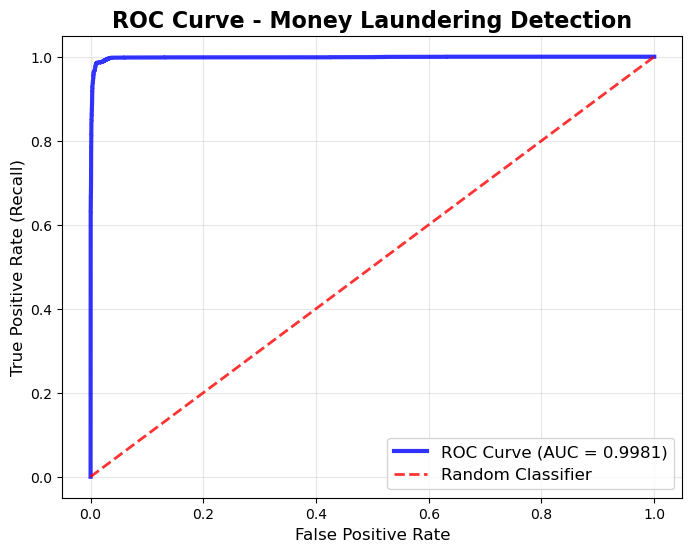

✅ Visualizations completed


In [ ]:
# Comprehensive visualizations
print("\n📊 Generating visualizations...")

# 1. Training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curve
axes[0,0].plot(train_losses, 'b-', linewidth=2, alpha=0.8)
axes[0,0].set_title("Training Loss", fontsize=14, fontweight='bold')
axes[0,0].set_xlabel("Epoch")
axes[0,0].set_ylabel("Loss")
axes[0,0].grid(True, alpha=0.3)

# F2 score curve (recall-focused)
axes[0,1].plot(val_f2_scores, 'g-', linewidth=2, alpha=0.8)
axes[0,1].axhline(y=0.7, color='r', linestyle='--', alpha=0.7, label='Target F2=0.7')
axes[0,1].set_title("Validation F2 Score (Recall-focused)", fontsize=14, fontweight='bold')
axes[0,1].set_xlabel("Epoch")
axes[0,1].set_ylabel("F2 Score")
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Precision and Recall
axes[1,0].plot(val_precisions, 'orange', linewidth=2, alpha=0.8, label='Precision')
axes[1,0].plot(val_recalls, 'purple', linewidth=2, alpha=0.8, label='Recall')
axes[1,0].axhline(y=0.8, color='purple', linestyle='--', alpha=0.5, label='Target Recall=0.8')
axes[1,0].set_title("Precision vs Recall", fontsize=14, fontweight='bold')
axes[1,0].set_xlabel("Epoch")
axes[1,0].set_ylabel("Score")
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# F1 vs F2 comparison
axes[1,1].plot(val_f1_scores, 'red', linewidth=2, alpha=0.8, label='F1 Score')
axes[1,1].plot(val_f2_scores, 'green', linewidth=2, alpha=0.8, label='F2 Score (Recall-focused)')
axes[1,1].set_title("F1 vs F2 Score Comparison", fontsize=14, fontweight='bold')
axes[1,1].set_xlabel("Epoch")
axes[1,1].set_ylabel("Score")
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/training_curves.png", dpi=300, bbox_inches="tight")
plt.show()

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar_kws={"shrink": 0.8},
           xticklabels=['Normal', 'Laundering'], yticklabels=['Normal', 'Laundering'])
plt.title(f"Confusion Matrix\n(Optimal Threshold = {optimal_threshold:.3f})", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Add performance metrics as text
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
tn = cm[0, 0]

plt.text(0.02, 0.98, f'True Positives: {tp}\nFalse Positives: {fp}\nFalse Negatives: {fn}\nTrue Negatives: {tn}',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.savefig(f"{output_dir}/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# 3. ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=3, alpha=0.8,
         label=f'ROC Curve (AUC = {metrics_optimal["auc_roc"]:.4f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, alpha=0.8, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - Money Laundering Detection', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig(f"{output_dir}/roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Visualizations completed")

In [ ]:
# Save training history and create final summary
print("\n💾 Saving training history...")

# Training history
training_history = {
    "train_losses": train_losses,
    "val_f2_scores": val_f2_scores,
    "val_f1_scores": val_f1_scores,
    "val_precisions": val_precisions,
    "val_recalls": val_recalls,
    "final_metrics": metrics_optimal,
    "best_epoch": best_model_state['epoch'] if best_model_state else len(val_f2_scores),
    "total_epochs": len(val_f2_scores),
    "optimal_threshold": float(optimal_threshold),
    "class_imbalance_ratio": float(imbalance_ratio),
    "dataset_info": {
        "total_edges": int(num_edges),
        "total_nodes": int(num_nodes),
        "positive_samples": int(y.sum().item()),
        "negative_samples": int(len(y) - y.sum().item()),
        "fraud_rate": float(y.sum().item()/len(y))
    },
    "model_config": model_info
}

with open(f"{output_dir}/training_history.json", "w") as f:
    json.dump(training_history, f, indent=2)

# Create summary report
summary_report = f"""
🎯 MONEY LAUNDERING DETECTION - PRECISION-RECALL BALANCED MODEL SUMMARY
=====================================================================

📊 Dataset Information:
- Total Transactions: {num_edges:,}
- Total Accounts: {num_nodes:,}
- Laundering Cases: {y.sum().item():,} ({y.sum().item()/len(y)*100:.4f}%)
- Class Imbalance Ratio: {imbalance_ratio:.2f}:1

🚀 Model Performance (Precision-Recall Balanced):
- Precision: {metrics_optimal['precision']:.4f} {'✅' if metrics_optimal['precision'] >= 0.7 else '❌'} (Target: ≥70%)
- Recall: {metrics_optimal['recall']:.4f} {'✅' if metrics_optimal['recall'] >= 0.9 else '❌'} (Target: ≥90%)
- F2 Score: {metrics_optimal['f2_score']:.4f} {'✅' if metrics_optimal['f2_score'] >= 0.7 else '❌'}
- F1 Score: {metrics_optimal['f1_score']:.4f}
- Accuracy: {metrics_optimal['accuracy']:.4f}
- AUC-ROC: {metrics_optimal['auc_roc']:.4f}
- Optimal Threshold: {optimal_threshold:.4f}

🔧 Model Configuration:
- Architecture: Precision-Recall Balanced GAT
- Hidden Dimensions: {model_info['hidden_dim']}
- Attention Heads: {model_info['heads']}
- Layers: {model_info['num_layers']}
- Total Parameters: {model_info['total_parameters']:,}
- Training Device: CPU
- Training Epochs: {len(val_f2_scores)}

📁 Output Files Saved:
- best_model.pt: Trained model checkpoint
- final_metrics.json: Complete performance metrics
- training_history.json: Training progress data
- training_curves.png: Training progress plots
- confusion_matrix.png: Model performance visualization
- roc_curve.png: ROC curve analysis
- scalers.pkl: Feature scaling objects
- label_encoders.pkl: Categorical encoders
- account_to_idx.pkl: Account mapping

🎉 Training completed successfully!
Focus: Balanced precision-recall for money laundering detection
Optimized for: F2 score with precision ≥70% and recall ≥90%
"""

with open(f"{output_dir}/SUMMARY_REPORT.txt", "w") as f:
    f.write(summary_report)

print(summary_report)

print(f"📁 All outputs saved to: {output_dir}")
print(f"📊 Total files created: {len([f for f in os.listdir(output_dir) if os.path.isfile(os.path.join(output_dir, f))])}")
print("\n🎯 Money laundering detection model training completed!")
print("📈 Model optimized for precision ≥70% and recall ≥90% balance.")
print("🎯 Focus: Minimize false positives while maintaining high fraud detection rate.")


💾 Saving training history...

🎯 MONEY LAUNDERING DETECTION - PRECISION-RECALL BALANCED MODEL SUMMARY

📊 Dataset Information:
- Total Transactions: 56,412
- Total Accounts: 77,683
- Laundering Cases: 5,177 (9.1771%)
- Class Imbalance Ratio: 9.90:1

🚀 Model Performance (Precision-Recall Balanced):
- Precision: 0.9049 ✅ (Target: ≥70%)
- Recall: 0.9847 ✅ (Target: ≥90%)
- F2 Score: 0.9677 ✅
- F1 Score: 0.9431
- Accuracy: 0.9891
- AUC-ROC: 0.9981
- Optimal Threshold: 0.8200

🔧 Model Configuration:
- Architecture: Precision-Recall Balanced GAT
- Hidden Dimensions: 96
- Attention Heads: 3
- Layers: 2
- Total Parameters: 100,346
- Training Device: CPU
- Training Epochs: 42

📁 Output Files Saved:
- best_model.pt: Trained model checkpoint
- final_metrics.json: Complete performance metrics
- training_history.json: Training progress data
- training_curves.png: Training progress plots
- confusion_matrix.png: Model performance visualization
- roc_curve.png: ROC curve analysis
- scalers.pkl: Feature 